In [1]:
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
conn = sqlite3.connect("/Users/Marcy_Student/Desktop/Marcy_Projects/Mod3_Final_Project-Theme-Park-Analytics/data/themepark.db")


In [3]:
# Query for daily performance data
daily_query = """
WITH daily AS ( 
    SELECT 
        d.date_iso,
        d.day_name,
        d.is_weekend,
        COUNT(DISTINCT v.visit_id) AS daily_visits,
        SUM(v.spend_cents_clean/100.0) AS daily_spend_USD
    FROM dim_date d
    LEFT JOIN fact_visits v ON v.date_id = d.date_id
    WHERE v.spend_cents_clean IS NOT NULL
    GROUP BY d.date_iso, d.day_name, d.is_weekend
    ORDER BY d.date_iso
)
SELECT * FROM daily;
"""

In [4]:
daily_df = pd.read_sql_query(daily_query, conn)
daily_df['date_iso'] = pd.to_datetime(daily_df['date_iso'])

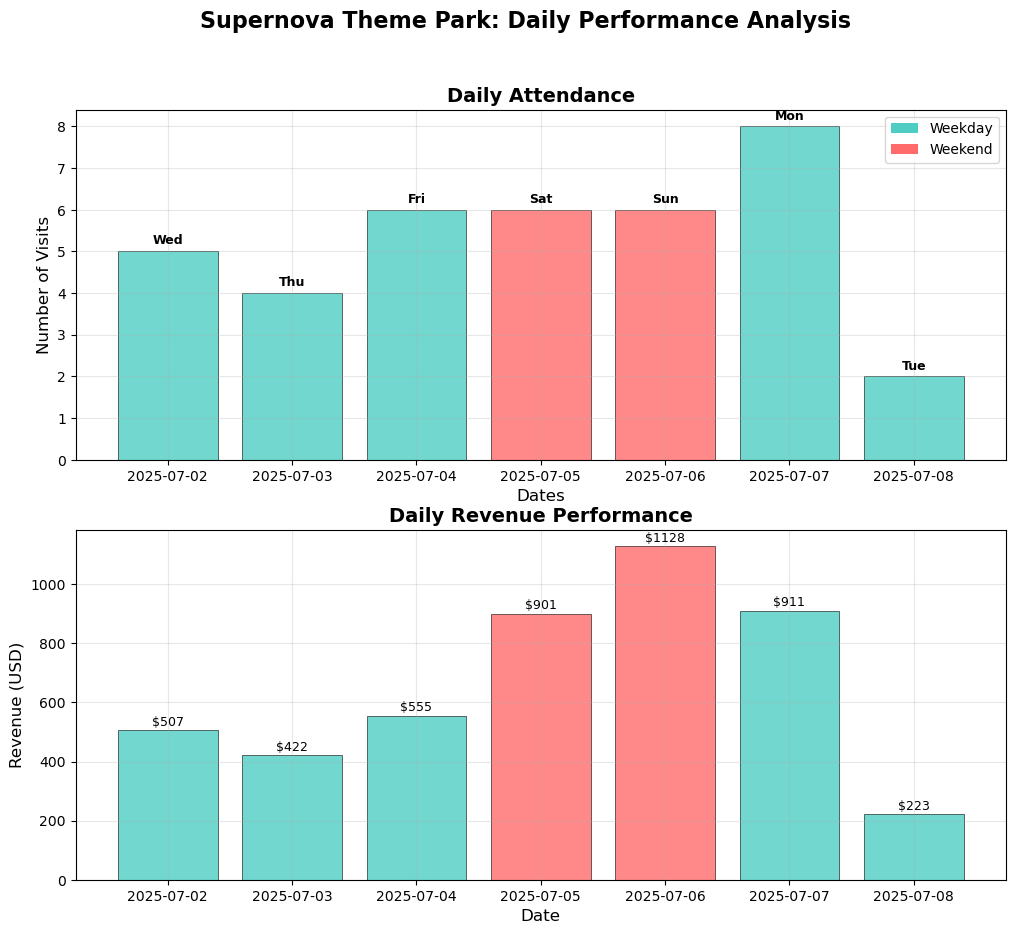

In [33]:
# Create subplot for daily performance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Supernova Theme Park: Daily Performance Analysis', fontsize=16, fontweight='bold')
# Top plot: Daily visits with weekend highlighting
bars1 = ax1.bar(daily_df['date_iso'], daily_df['daily_visits'], 
                color=['#FF6B6B' if weekend else '#4ECDC4' for weekend in daily_df['is_weekend']],
                alpha=0.8, edgecolor='black', linewidth=0.5)

ax1.set_title('Daily Attendance', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Visits', fontsize=12)
ax1.set_xlabel('Dates', fontsize=12)
ax1.tick_params(axis='x')
ax1.grid(True, alpha=0.3)

# Add day labels on bars
for i, (bar, day) in enumerate(zip(bars1, daily_df['day_name'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{day[:3]}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Bottom plot: Daily revenue
bars2 = ax2.bar(daily_df['date_iso'], daily_df['daily_spend_USD'], 
                color=['#FF6B6B' if weekend else '#4ECDC4' for weekend in daily_df['is_weekend']],
                alpha=0.8, edgecolor='black', linewidth=0.5)

ax2.set_title('Daily Revenue Performance', fontsize=14, fontweight='bold')
ax2.set_ylabel('Revenue (USD)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.tick_params(axis='x')
ax2.grid(True, alpha=0.3)

# Add revenue labels on bars
for bar, revenue in zip(bars2, daily_df['daily_spend_USD']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'${revenue:.0f}', ha='center', va='bottom', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#4ECDC4', label='Weekday'),
                   Patch(facecolor='#FF6B6B', label='Weekend')]
ax1.legend(handles=legend_elements, loc='upper right')

Now we save this graph the directory figures

In [7]:
plt.tight_layout()
plt.savefig('/Users/Marcy_Student/Desktop/Marcy_Projects/Mod3_Final_Project-Theme-Park-Analytics/figures/daily_performance_analysis.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [8]:
# Query for wait time and satisfaction data
wait_satisfaction_query = """
SELECT 
    a.attraction_name,
    a.category,
    re.wait_minutes,
    re.satisfaction_rating,
    COUNT(*) as ride_count
FROM fact_ride_events re
JOIN dim_attraction a ON re.attraction_id = a.attraction_id
WHERE re.wait_minutes IS NOT NULL 
    AND re.satisfaction_rating IS NOT NULL
    AND re.wait_minutes > 0
GROUP BY a.attraction_name, a.category, re.wait_minutes, re.satisfaction_rating
ORDER BY a.attraction_name, re.wait_minutes;
"""

In [9]:
#read the query in a pandas dataframe
wait_sat_df = pd.read_sql_query(wait_satisfaction_query, conn)

Let's create an aggregated data for the visualization


In [10]:
# I decided to select the fields in sql and now to aggregate the mean and sum after grouping by 'attraction_name' and 'category' using groupby
agg_data = wait_sat_df.groupby(['attraction_name', 'category']).agg({
    'wait_minutes': 'mean',
    'satisfaction_rating': 'mean',
    'ride_count': 'sum'
}).reset_index()

Now le't create a scatter plot to visualise how the 


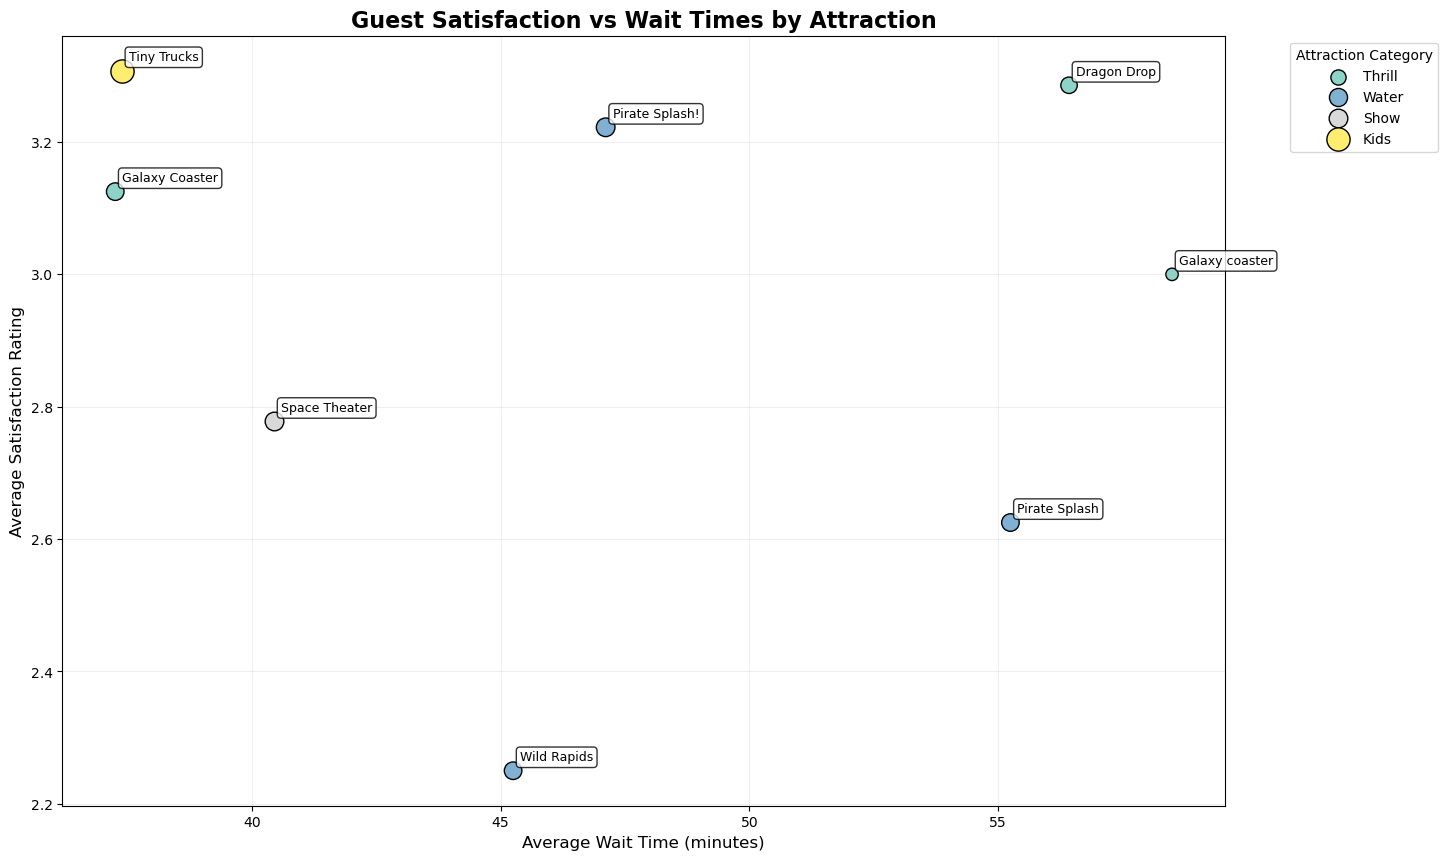

In [32]:
fig, ax = plt.subplots(figsize=(15, 10))
# Color map for categories
categories = agg_data['category'].unique() # to get each category one time.
colors = plt.cm.Set3(np.linspace(0, 1, len(categories))) #apply one color to each catgory
color_map = dict(zip(categories, colors))

for category in categories:
    cat_data = agg_data[agg_data['category'] == category]
    scatter = ax.scatter(cat_data['wait_minutes'], cat_data['satisfaction_rating'], 
                        s=cat_data['ride_count']*20,  # Bubble size
                        c=[color_map[category]], 
                        alpha=1, 
                        edgecolors='black',
                        linewidth=1,
                        label=category)
# Add attraction labels
for idx, row in agg_data.iterrows():
    ax.annotate(row['attraction_name'], 
                (row['wait_minutes'], row['satisfaction_rating']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
# Customize plot
ax.set_title('Guest Satisfaction vs Wait Times by Attraction', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Average Wait Time (minutes)', fontsize=12)
ax.set_ylabel('Average Satisfaction Rating', fontsize=12)
ax.grid(True, alpha=0.2)
ax.legend(title='Attraction Category', bbox_to_anchor=(1.05, 1), loc='upper left')




Now we can save the graph 

In [12]:
plt.tight_layout()
plt.savefig('/Users/Marcy_Student/Desktop/Marcy_Projects/Mod3_Final_Project-Theme-Park-Analytics/figures/wait_satisfaction_analysis.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [13]:
# Query for Customers Lifetime Value and ticket analysis
clv_ticket_query = """
WITH guest_summary AS (
    SELECT 
        g.guest_id,
        g.home_state,
        COUNT(DISTINCT v.visit_id) as visit_frequency,
        SUM(v.spend_cents_clean/100.0) as lifetime_value,
        t.ticket_type_name as primary_ticket_type
    FROM dim_guest g
    JOIN fact_visits v ON g.guest_id = v.guest_id
    JOIN dim_ticket t ON v.ticket_type_id = t.ticket_type_id
    WHERE v.spend_cents_clean IS NOT NULL
    GROUP BY g.guest_id, g.home_state, t.ticket_type_name
),
ticket_performance AS (
    SELECT 
        t.ticket_type_name,
        COUNT(DISTINCT v.visit_id) as total_visits,
        AVG(v.spend_cents_clean/100.0) as avg_spend_per_visit,
        SUM(v.spend_cents_clean/100.0) as total_revenue
    FROM fact_visits v
    JOIN dim_ticket t ON v.ticket_type_id = t.ticket_type_id
    WHERE v.spend_cents_clean IS NOT NULL
    GROUP BY t.ticket_type_name
)
SELECT * FROM ticket_performance
ORDER BY total_revenue DESC;
"""

In [14]:
#read the query in a pandas dataframe
ticket_perf_df = pd.read_sql_query(clv_ticket_query, conn)

In [15]:
print(ticket_perf_df)

  ticket_type_name  total_visits  avg_spend_per_visit  total_revenue
0         Day Pass            16           142.883125        2286.13
1              VIP            16           119.530625        1912.49
2      Family Pack             5            89.908000         449.54


In [16]:
# Also get top states by Customer life time values 
state_clv_query = """
SELECT 
    g.home_state,
    COUNT(DISTINCT g.guest_id) as guest_count,
    AVG(total_clv) as avg_clv,
    SUM(total_clv) as total_clv
FROM (
    SELECT 
        g.guest_id,
        g.home_state,
        SUM(v.spend_cents_clean/100.0) as total_clv
    FROM dim_guest g
    JOIN fact_visits v ON g.guest_id = v.guest_id
    WHERE v.spend_cents_clean IS NOT NULL
    GROUP BY g.guest_id, g.home_state
) g
GROUP BY g.home_state
ORDER BY total_clv DESC
LIMIT 8;
"""

In [17]:
#read the query in a pandas dataframe
state_clv_df = pd.read_sql_query(state_clv_query, conn)


In [18]:
print(state_clv_df)

   home_state  guest_count     avg_clv  total_clv
0  California            3  602.110000    1806.33
1    New York            3  515.443333    1546.33
2     Florida            2  373.910000     747.82
3       Texas            2  273.840000     547.68


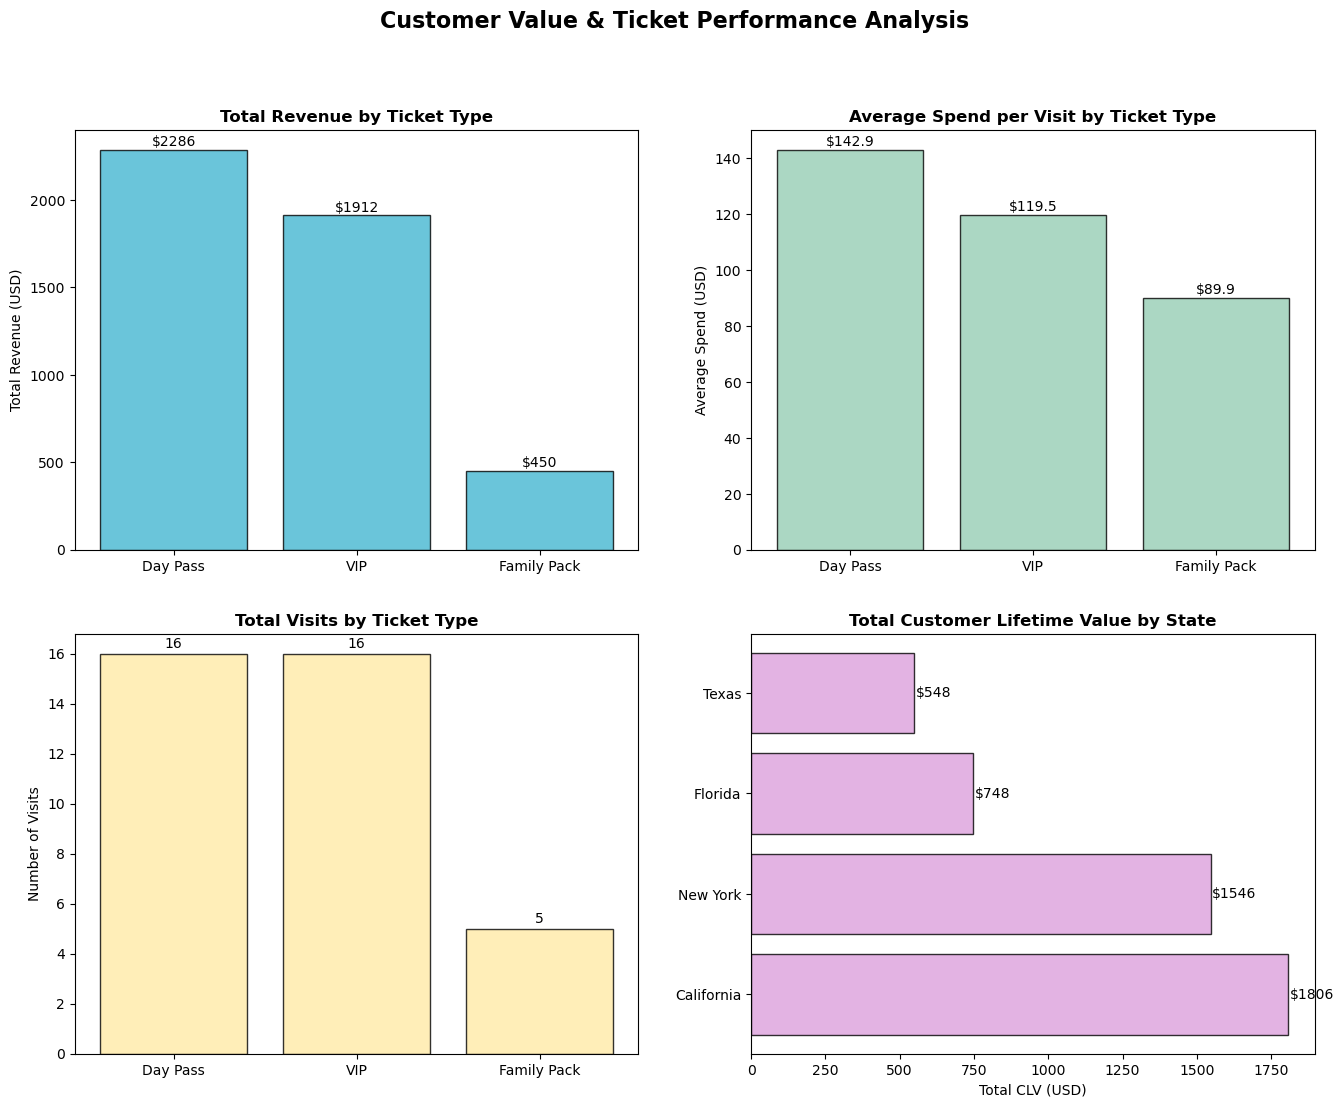

In [19]:
# Create subplot for ticket and CLV analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Customer Value & Ticket Performance Analysis', fontsize=16, fontweight='bold')

# Top left: Ticket performance by revenue
bars1 = ax1.bar(ticket_perf_df['ticket_type_name'], ticket_perf_df['total_revenue'], 
                color='#45B7D1', alpha=0.8, edgecolor='black')
ax1.set_title('Total Revenue by Ticket Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Revenue (USD)')
ax1.tick_params(axis='x')
for bar, revenue in zip(bars1, ticket_perf_df['total_revenue']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'${revenue:.0f}', ha='center', va='bottom', fontsize=10)
    
    # Top right: Average spend per visit by ticket type
bars2 = ax2.bar(ticket_perf_df['ticket_type_name'], ticket_perf_df['avg_spend_per_visit'], 
                color='#96CEB4', alpha=0.8, edgecolor='black')
ax2.set_title('Average Spend per Visit by Ticket Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Spend (USD)')
ax2.tick_params(axis='x')
for bar, avg_spend in zip(bars2, ticket_perf_df['avg_spend_per_visit']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'${avg_spend:.1f}', ha='center', va='bottom', fontsize=10)
    
# Bottom left: Total visits by ticket type
bars3 = ax3.bar(ticket_perf_df['ticket_type_name'], ticket_perf_df['total_visits'], 
                color='#FFEAA7', alpha=0.8, edgecolor='black')
ax3.set_title('Total Visits by Ticket Type', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Visits')
ax3.tick_params(axis='x')
for bar, visits in zip(bars3, ticket_perf_df['total_visits']):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{visits}', ha='center', va='bottom', fontsize=10)
    
# Bottom right: CLV by state
bars4 = ax4.barh(state_clv_df['home_state'], state_clv_df['total_clv'], 
                 color='#DDA0DD', alpha=0.8, edgecolor='black')
ax4.set_title('Total Customer Lifetime Value by State', fontsize=12, fontweight='bold')
ax4.set_xlabel('Total CLV (USD)')
for bar, clv in zip(bars4, state_clv_df['total_clv']):
    width = bar.get_width()
    ax4.text(width + 5, bar.get_y() + bar.get_height()/2.,
             f'${clv:.0f}', ha='left', va='center', fontsize=10)


Now we can save this beautiful graph 😍

In [97]:
plt.tight_layout()
plt.savefig('/Users/Marcy_Student/Desktop/Marcy_Projects/Mod3_Final_Project-Theme-Park-Analytics/figures/clv_ticket_analysis.png', bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>